In [182]:
import numpy as np
import pandas as pd

from skimage import io
from skimage.filters import threshold_otsu, gaussian
from skimage import measure
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_opening, binary_closing, ball

import os
from matplotlib import pyplot as plt
import pandas as pd
import napari
import tifffile
# from threadpoolctl import threadpool_limits

from scipy import spatial
from scipy import ndimage as ndi
from scipy.ndimage import map_coordinates
from scipy.ndimage.morphology import binary_fill_holes
from scipy.integrate import solve_ivp
from scipy import interpolate

from sklearn.preprocessing import normalize
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import manifold

# from sklearn_extra.cluster import KMedoids

import zarr

import pydeform.sitk_api as pydeform
import itertools
import ray
from tqdm import tqdm
import ants
import SimpleITK as sitk

from vispy import color
from vispy.color import Colormap

import pickle
import xarray as xr

In [205]:
import importlib
from morphotrack import trace
import morphotrack.variables
import morphotrack.points
import morphotrack.track
import morphotrack.binary
importlib.reload(morphotrack.binary)

# num_cpus=48
# ray.init(num_cpus=num_cpus, ignore_reinit_error=True)
turbo_dark = Colormap(morphotrack.variables.turbo_list)

In [3]:
io_directory = '/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack'
vessel_downscale = io.imread(os.path.join(io_directory,'R01_ch561_10um.tif'))# np.load()

# load autofluorescence/nuclei for segmentation
nuclei = io.imread(os.path.join(io_directory,'R02_ch488_10um.tif'))# autofl_zarr['0'][:]
voxel_size = [10, 10, 10]

# load a mask of a white matter 
white_matter = io.imread(os.path.join(io_directory,'white_matter.tif'))==1
white_matter = morphotrack.binary.extract_largest_object_from_binary(white_matter)
white_matter = binary_opening(white_matter,ball(5))
white_matter = binary_fill_holes(white_matter)

# load a mask of a layer 1
layer1 = io.imread(os.path.join(io_directory,'l1.tif'))==1
layer1 = morphotrack.binary.extract_largest_object_from_binary(layer1)
layer1 = binary_opening(layer1,ball(5))
layer1 = binary_fill_holes(layer1)

In [317]:
# visual sanity check
viewer= napari.Viewer()
viewer.add_image(layer1)
viewer.add_image(white_matter)
viewer.add_image(nuclei)

<Image layer 'nuclei' at 0x7f06201578e0>

In [318]:
def seed_selection(seeds, normals, flow_on_seeds, n_clusters=6, cluster_selection='min'):
    """
    Select the seeds on the surface of interest. 
    """
    # Calculate dot product of normal vector and flows
    seeds_dot_product = np.sum(normals*flow_on_seeds, axis=1) # This will return the dot product.

    # Start clusterings
    features = np.concatenate((seeds,normals,seeds_dot_product[...,np.newaxis]),axis=1) # Make feature matrix, xyz coordinates + normal vectors + dot products
    scaler = StandardScaler().fit(features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaler.transform(features)) # Clustering 

    # Extract seeds in the cluster of interest.
    if cluster_selection=='min':
        cluster_of_interest = np.argmin(kmeans.cluster_centers_[:,-1]) # Minimum in this case. Could be maximum depending on the orientation of the tissue or guide vector.
    elif cluster_selection=='max':
        cluster_of_interest = np.argmax(kmeans.cluster_centers_[:,-1])
    else:
        print("error")
        return None
    return (kmeans.labels_==cluster_of_interest)

In [5]:
# read cellular coordinate
cells_info = pd.read_csv('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0) # the unit is original voxel.
scaling_factor = np.asarray([3,0.65,0.65])
cell_coords = cells_info.loc[:,['centroid-0','centroid-1','centroid-2']] * scaling_factor / 10# convert unit to 10 um for consistency
cell_coords = cell_coords.to_numpy()

# make kdTree of the nuclei
coords_tree = spatial.KDTree(cell_coords)

In [8]:
%%time
### selection of the outer most cells.
import alphashape
import networkx as nx

# convex hull is not successful. Try alpha shape instead.
# 750,000 takes ~7 min.
downsample = 10
alpha = alphashape.alphashape(cell_coords[::downsample,:], 0.1)

# use network to select the largest point clouds
groups = nx.connected_components(alpha.vertex_adjacency_graph)
groups = list(groups)
# select the largest point clouds
idx = groups[np.asarray([len(c) for c in groups]).argmax()]
ver = np.asarray(alpha.vertices[tuple(idx),:])
nor = np.asarray(alpha.vertex_normals[tuple(idx),:])

# check the selected vertices
viewer = napari.Viewer()
viewer.add_points(
    ver,
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



CPU times: user 3min 56s, sys: 813 ms, total: 3min 57s
Wall time: 3min 51s


<Points layer 'ver' at 0x7f061c2bfe80>

In [9]:
# load model
clf = pickle.load(open(os.path.join(io_directory,'model.pkl'), 'rb'))
norm_flow_on_coordinate = morphotrack.points.get_norm_flow_on_coordinate(clf.degree, clf)

In [14]:
selection = seed_selection(ver, nor, norm_flow_on_coordinate(ver), n_clusters=4)
points = ver[selection]

# np.save('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/surface_points.npy',points)
# points = np.load('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/surface_points.npy')

viewer = napari.Viewer()
viewer.add_points(
    points,
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)

# seeds_df = pd.DataFrame(ver[selection], columns=['x0','x1','x2'])


/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Points layer 'points' at 0x7f0616b89040>

In [8]:
# points = np.load('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/surface_points.npy')

## Seeding and extending

In [179]:
%%time
# Segmentation of the image
background_val = 500
segmented_tissue = (nuclei>background_val)
segmented_tissue = morphotrack.binary.extract_largest_object_from_binary(segmented_tissue)
segmented_tissue = binary_opening(segmented_tissue,ball(5))

CPU times: user 48.4 s, sys: 239 ms, total: 48.6 s
Wall time: 47.9 s


In [18]:
polynomial_vectorfield = morphotrack.track.polynomial_vectorfield_generator(clf.coef_, clf.degree)

In [19]:
tracker = morphotrack.track.FieldTracker(polynomial_vectorfield, points)

In [20]:
t_start = 0
t_end = 500
tracker.solve_ode(t_start,t_end)

(pid=3471472) /home/tmurakami/src/morphotrack/morphotrack/track.py:31: RuntimeWarning: overflow encountered in double_scalars
(pid=3471472)   (b * (x0 ** ij_powers[i, 0]) * (x1 ** ij_powers[i, 1]) * (x2 ** ij_powers[i, 2]) for i, b in enumerate(coeff)))
(pid=3471472) /home/tmurakami/src/morphotrack/morphotrack/track.py:30: RuntimeWarning: invalid value encountered in double_scalars
(pid=3471472)   return sum(
(pid=3471576) /home/tmurakami/src/morphotrack/morphotrack/track.py:31: RuntimeWarning: overflow encountered in double_scalars
(pid=3471576)   (b * (x0 ** ij_powers[i, 0]) * (x1 ** ij_powers[i, 1]) * (x2 ** ij_powers[i, 2]) for i, b in enumerate(coeff)))
(pid=3471576) /home/tmurakami/src/morphotrack/morphotrack/track.py:30: RuntimeWarning: invalid value encountered in double_scalars
(pid=3471576)   return sum(
(pid=3471544) /home/tmurakami/src/morphotrack/morphotrack/track.py:31: RuntimeWarning: overflow encountered in double_scalars
(pid=3471544)   (b * (x0 ** ij_powers[i, 0]) * (

In [22]:
def fill_value_in_range(array, index_array, value=255.):
    '''
    The function fill the value in a given array using indexing array. 
    The indexing array can have the index outside of the given array. The position indicated by index array is filled with the value.
    The outside index will be disregarded. 
    array: numpy array to be filled with value.
    index_array: numpy array for indexing. Each column has the position of the array to be filled.
    value: value to be filled. int or numpy array with the size of column number in index_array.
    '''
    dim = array.ndim
    # Select indices within the range of the array.
    column_to_select = np.all(
        [np.all([index_array[i,:] >= 0 for i in range(dim)], axis=0), np.all([index_array[i,:] < (array.shape[i] - 0.5) for i in range(dim)], axis=0)],
        axis=0
    )
    select_idx = index_array[:,column_to_select]
    select_idx = np.around(select_idx).astype(int)
    
    # Fill the value in the array.
    if isinstance(value,np.ndarray):
        array[tuple([select_idx[i,:] for i in range(dim)])] = value[column_to_select]
    else:
        array[tuple([select_idx[i,:] for i in range(dim)])] = value
    return array

In [23]:
seed_choice = tracker.t_positions.track.data

In [24]:
# Export image if necessary
palette = [
    Colormap([[1.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 1.0]]),
    Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 1.0, 0.0, 1.0]]),
    Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 1.0, 1.0]])]

if True:
    flow_img = np.zeros(vessel_downscale.shape+(3,))
    for seed_num in seed_choice[::5]:
        
        position = tracker.t_positions.isel(track=seed_num).data.T
        position[np.isnan(position)] = 0
        for i in range(3):
            flow_vector = abs(norm_flow_on_coordinate(position.T)[:,i])
            flow_img[...,i] = fill_value_in_range(flow_img[...,i],position,flow_vector)
    for i in range(3):
        flow_img[...,i] = flow_img[...,i]*segmented_tissue
    viewer = napari.Viewer()
    viewer.add_image(vessel_downscale, contrast_limits=[0,20000], rgb=False, name='sma', colormap='gray', blending='additive')
    for i in range(3):
        viewer.add_image(flow_img[...,i], contrast_limits=[0,1], rgb=False, name=i, colormap=palette[i], blending='translucent')
    viewer.add_image(segmented_tissue, contrast_limits=[0,2], rgb=False, name='mask', colormap='cyan', blending='additive', multiscale=False, visible=False)

In [25]:
import morphotrack.points
import morphotrack.track
importlib.reload(morphotrack.points)
importlib.reload(morphotrack.track)

<module 'morphotrack.track' from '/home/tmurakami/src/morphotrack/morphotrack/track.py'>

In [26]:
track = tracker.t_positions
flow = tracker.apply_function_to_position(norm_flow_on_coordinate)

In [27]:
def count_around_position(coords_tree, half_thickness, radius):
    def f(arr1, arr2):
        a,_,_ = morphotrack.points.count_around_position(arr1, arr2, coords_tree, half_thickness, radius=radius)
        return a
    return f

## Count in-kernel cells

In [28]:
%%time
half_thickness = 2.5 # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer

kernel_counts = tracker.apply_function_to_position_with_array(count_around_position(coords_tree, half_thickness, radius), flow)
kernel_counts = kernal_counts.fillna(0)

CPU times: user 6min 1s, sys: 42 s, total: 6min 43s
Wall time: 4min 25s


## Filtering with white matter and tissue shape

In [38]:
def fetch_value_in_array(array):
    def f(index):
        a = morphotrack.track.fetch_value_in_range(array, index, return_inloc=False)
        return a
    return f

In [ ]:
def extract_largest_segment_from_binary(array, structure=np.ones((3))):
    """
    array (1d array):
    """
    label_objects, nb_labels = ndi.label(array, structure=structure)
    sizes = np.bincount(label_objects)
    sizes[0] = 0
    largest_segment = (label_objects == np.argmax(sizes))

In [225]:
def extract_segment(structure):
    def f(arr):
        return morphotrack.binary.extract_largest_object_from_binary(arr, structure)
    return f 

In [185]:
# get binary mask for gray matter
gray_candidate = (1-white_matter)*segmented_tissue

In [326]:
# get segments where tracks are in gray matter
gray_loc = tracker.apply_function_to_position(fetch_value_in_array(gray_candidate))
gray_loc = gray_loc.astype(float).fillna(0)
gray_loc.data = np.apply_along_axis(lambda a:morphotrack.binary.extract_largest_object_from_binary(a, np.ones(3)), axis=1, arr=gray_loc.data) # extract the longest segment

# make filter based on the size of the segment
filters = []
size_threshold = 100
filters.append(gray_loc.sum(dim='time')>=size_threshold)

# make filter based on one edge is in white matter
white_loc = tracker.apply_function_to_position(fetch_value_in_array(white_matter))
white_loc = white_loc.astype(float).fillna(0)

temp = np.apply_along_axis(lambda a:binary_dilation(a, np.hstack([np.zeros(10),np.ones(10)])), axis=1, arr=gray_loc.data)
filters.append(((temp-gray_loc)*white_loc).sum(dim='time')>0)

# make filter based on inclusion of layer1
l1_loc = tracker.apply_function_to_position(fetch_value_in_array(layer1))
l1_loc = l1_loc.astype(float).fillna(0)
filters.append(l1_loc.sum(dim='time')>0)

# dilate to obtain redundancy for alignment
gray_loc.data = np.apply_along_axis(lambda a:binary_dilation(a, np.ones(20)), axis=1, arr=gray_loc.data)

# summarize filters
filters = xr.concat(filters,dim='filt')

In [341]:
# Export image if necessary
palette = [
    Colormap([[1.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 1.0]]),
    Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 1.0, 0.0, 1.0]]),
    Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 1.0, 1.0]])]

if True:
    flow_img = np.zeros(vessel_downscale.shape+(3,))
    for seed_num in filters.track[filters.all(dim='filt').data].data[::5]:
        
        position = tracker.t_positions.isel(track=seed_num).data.T
        position[np.isnan(position)] = 0
        position = position[:,gray_loc.isel(track=seed_num).data]
        for i in range(3):
            flow_vector = abs(norm_flow_on_coordinate(position.T)[:,i])
            flow_img[...,i] = fill_value_in_range(flow_img[...,i],position,flow_vector)
    for i in range(3):
        flow_img[...,i] = flow_img[...,i]*segmented_tissue
    viewer = napari.Viewer()
    viewer.add_image(vessel_downscale, contrast_limits=[0,20000], rgb=False, name='sma', colormap='gray', blending='additive')
    for i in range(3):
        viewer.add_image(flow_img[...,i], contrast_limits=[0,1], rgb=False, name=i, colormap=palette[i], blending='translucent')
    viewer.add_image(segmented_tissue, contrast_limits=[0,2], rgb=False, name='mask', colormap='cyan', blending='additive', multiscale=False, visible=False)
    viewer.add_image(nuclei, contrast_limits=[0,20000], rgb=False, name='nuclei', colormap='gray', blending='additive', multiscale=False, visible=False)

## Alignment
create xarray dataset for alignment

In [533]:
def make_displacement_map(position_arr):
    coords = np.meshgrid(*[range(x) for x in position_arr.shape], indexing='ij')
    coords = np.array(coords).astype(np.int16)
    coords[0,:,:] = position_arr
    
    return coords

In [527]:
def standard_generator(target,idx):
    std_track = target.sel(track=idx)
    standard = target.copy()
    standard[:] = std_track
    standard.attrs['standard_seed'] = idx
    
    return standard

### generation of target and standard
save selected tracks and all their info as an xarray dataset

In [451]:
# get tracks for analysis
track_selection = filters.track[filters.all(dim='filt')]

# create xarray dataset
track_ds = xr.Dataset(data_vars={'Kernel_counts': kernel_counts.isel(track=track_selection), 'Gray_loc': gray_loc.isel(track=track_selection)})
track_ds['Gray_counts'] = track_ds.Kernel_counts * track_ds.Gray_loc

# position and flow for future reference
track_ds['Position'] = tracker.t_positions.isel(track=track_selection.data)
track_ds['Flow'] = flow.isel(track=track_selection.data)
track_ds['Seeds'] = tracker.seeds_xr.isel(track=track_selection.data)


In [541]:
# get a standard as a template of alignment
std_pos = morphotrack.points.pick_median_nearest_point(track_ds['Seeds'],1)
std_seed = track_ds['Seeds'][std_pos,:].track.data

In [462]:
def find_nonzero_start_end_1d(track):
    """
    Find the first and last position where non-zero values appear. 
    Arguments:
        track (1darray): 
    Return:
        start (int): index of first non-zero
        end (int): index of last non-zero
    """
    # identify the initial position where the counts are more than zero 
    start = np.argmax(track!=0)
    # identify last position where the counts are more than zero
    end = (segment.size - np.argmax(track[::-1]!=0)) - 1 
    
    return start, end

In [469]:
def find_nonzero_start_end(arr,axis=0):
    """
    Find the first and last position where non-zero values appear. 
    Arguments:
        arr (ndarray): 
    Return:
        ndarray: first values to be start, the last values to be end

    """
    positions = np.apply_along_axis(find_nonzero_start_end_1d, axis, arr)
    
    return positions

In [ ]:
def clip(arr):
    arr[arr<0] = 0; arr[arr>arr.size-1] = arr.size-1
    return arr

In [653]:
def get_warp_args_1d(arr1,arr2,size=100):
    """
    Arguments:
        arr1, arr2 (ndarray):
        size(int):
    Return:
        ndarray: index to move second one to first one
    """
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    # args = np.interp(np.arange(size),arr1,arr2)
    f = interpolate.interp1d(arr1,arr2,fill_value='extrapolate')
    args = f(np.arange(size))
    
    # clipping
    args = clip(args)
    
    return args

In [624]:
def positional_mapping(arr1,arr2):
    return map_coordinates(arr1.T, make_displacement_map(arr2.T), order=1, mode='constant').T

In [654]:
def shift_to_standard(counts,standard_seed):
    """
    Align the nonzero start/end position of the tracks to the nonzero start/end position of the standard track.
    Arguments:
        counts (xarray): The name of the coordinates should include track and time.
        standard_seed: the index of the standard track.
    Return:
        args
        disps
    """
    standard_start_end_pos = np.asarray(find_nonzero_start_end_1d(counts.sel(track=standard_seed).data))
    start_end_pos = find_nonzero_start_end(counts,axis=counts.get_axis_num('time'))
    size = counts.time.size
    
    # get positions (index) to warp.
    standard2target = np.apply_along_axis(lambda a : get_warp_args_1d(a,standard_start_end_pos,size),counts.get_axis_num('time'),start_end_pos)
    target2standard = np.apply_along_axis(lambda a : get_warp_args_1d(standard_start_end_pos,a,size),counts.get_axis_num('time'),start_end_pos)
    
    # the following should be cleaned up but work for now.
    standard_counts = standard_generator(counts, standard_seed).data
    displaced_std2tar = positional_mapping(standard_counts, standard2target)
    displaced_tar2std = positional_mapping(counts, target2standard)
    
    standard2target_xr = counts.copy(); standard2target_xr[:] = standard2target
    target2standard_xr = counts.copy(); target2standard_xr[:] = target2standard
    args = xr.concat([standard2target_xr, target2standard_xr],pd.Index(['s2t', 't2s'],name='displacement'))
    args.name = 'Linear_args'
    
    displaced_std2tar_xr = counts.copy(); displaced_std2tar_xr[:] = displaced_std2tar
    displaced_tar2std_xr = counts.copy(); displaced_tar2std_xr[:] = displaced_tar2std
    disps = xr.concat([displaced_std2tar_xr, displaced_tar2std_xr],pd.Index(['s2t', 't2s'],name='displacement'))
    disps.name = 'Linear_displacement'
    
    return args, disps

In [655]:
standard = standard_generator(track_ds.Gray_counts,std_seed)
args, disps = shift_to_standard(track_ds.Gray_counts,std_seed)

# save to track dataset
track_ds['Standard'] = standard
track_ds['Linear_arg'] = args
track_ds['Linear_displacement'] = disps

In [729]:
viewer = napari.Viewer()
viewer.add_image(track_ds.Gray_counts,colormap='green',blending='additive',visible=False)
viewer.add_image(track_ds.Standard,colormap='green',blending='additive')
viewer.add_image(track_ds.Linear_displacement.sel(displacement='t2s'),colormap='magenta',blending='additive')

<Image layer 'Image [2]' at 0x7f06067bd190>

In [691]:
def tracks_aligner(fix, mov, clipping=True, settings=morphotrack.variables.settings,num_threads=-1,use_gpu=True,**kwargs):
    """
    Wrapping deform (https://github.com/simeks/deform). Assume 1d arrays as inputs
    Arguments:
        fix (1darray): fixed target. 
        mov (1darray): moving object.
    Return:
        mov2fix_args: the index to warp mov to fix
        fix2mov_args: the index to warp fix to mov. Please note deform uses non symmetric transformation.
    """
    
    fix_itk = sitk.Cast(sitk.GetImageFromArray(fix[:, np.newaxis, np.newaxis]),sitk.sitkFloat32)
    mov_itk = sitk.Cast(sitk.GetImageFromArray(mov[:, np.newaxis, np.newaxis]),sitk.sitkFloat32)
    df_sitk = pydeform.register(
        fix_itk,
        mov_itk,
        settings=morphotrack.variables.settings,
        num_threads=num_threads,
        use_gpu=use_gpu,
        **kwargs
    )
    pos = sitk.GetArrayFromImage(df_sitk)[:,0,0,2]
    mov2fix_args = np.arange(pos.size)+pos
    fix2mov_args = np.arange(pos.size)-pos
    
    if clipping:
        mov2fix_args = clip(mov2fix_args)
        fix2mov_args = clip(fix2mov_args)
    
    return mov2fix_args, fix2mov_args

In [699]:
def track_wise_aligner(fix2d, mov2d, **kwargs):
    """
    Wrapping deform (https://github.com/simeks/deform). Assume 2d arrays as inputs. Each row is a track.
    Arguments:
        fix (2darray): fixed target. 
        mov (2darray): moving object.
    Return:
        args: the index to warp mov to fix
    """
    mov2fix_args = np.zeros(fix2d.shape,dtype=float)
    fix2mov_args = np.zeros(fix2d.shape,dtype=float)

    for l in tqdm(np.arange(fix2d.shape[0])):
        mov2fix_args[l,:], fix2mov_args[l,:] = tracks_aligner(fix2d[l,:], mov2d[l,:], **kwargs)
        
    return mov2fix_args, fix2mov_args

In [709]:
def composite_displacement(disp1st,disp2nd):
    comp_disp = positional_mapping(disp1st, disp2nd)
    return comp_disp

In [705]:
non_linear_args = track_wise_aligner(track_ds.Standard.data, track_ds.Linear_displacement.sel(displacement='t2s').data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1724/1724 [08:33<00:00,  3.36it/s]


In [739]:
# store non linear displacement in xarray
non_linear_arg_xr = track_ds.Linear_arg.copy()
non_linear_arg_xr[:] = np.asarray(non_linear_args[::-1])
track_ds['Nonlinear_arg'] = non_linear_arg_xr

In [749]:
# make total displacement 
comp_disps = []
for x in track_ds.Nonlinear_arg.displacement.data:
    comp_disps.append(composite_displacement(track_ds.Linear_arg.sel(displacement=x),track_ds.Nonlinear_arg.sel(displacement=x)))

# store total displacement in xarray
total_arg_xr = track_ds.Linear_arg.copy()
total_arg_xr[:] = np.asarray(comp_disps)
track_ds['Total_arg'] = total_arg_xr

In [750]:
# make total warped tracks
s2t_non_linear_warped = positional_mapping(track_ds.Standard, track_ds.Total_arg.sel(displacement='s2t'))
t2s_non_linear_warped = positional_mapping(track_ds.Gray_counts, track_ds.Total_arg.sel(displacement='t2s'))

# store total warp in xarray
total_warp_xr = track_ds.Linear_arg.copy()
total_warp_xr[:] = np.asarray([s2t_non_linear_warped, t2s_non_linear_warped])
track_ds['Total_displacement'] = total_warp_xr

In [761]:
track_ds

<xarray.Dataset>
Dimensions:              (time: 500, track: 1724, space: 3, displacement: 2)
Coordinates:
  * time                 (time) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * track                (track) int64 1188 1247 1251 1271 ... 6617 6624 6649
  * space                (space) int64 0 1 2
  * displacement         (displacement) object 's2t' 't2s'
Data variables:
    Kernel_counts        (track, time) float64 285.0 288.0 303.0 ... 0.0 0.0 0.0
    Gray_loc             (track, time) bool True True True ... False False False
    Gray_counts          (track, time) float64 285.0 288.0 303.0 ... 0.0 0.0 0.0
    Position             (track, time, space) float64 280.7 312.5 ... nan nan
    Flow                 (track, time, space) float64 -0.8726 0.4883 ... nan nan
    Seeds                (track, space) float64 280.7 312.5 ... 27.47 326.5
    Standard             (track, time) float64 360.0 414.0 447.0 ... 0.0 0.0 0.0
    Linear_arg           (displacement, track, time) float64 0.0 1.199 ... 299.4
    Linear_displacement  (displacement, track, time) float64 360.0 414.0 ... 0.0
    Nonlinear_arg        (displacement, track, time) float64 35.0 36.0 ... 499.0
    Total_arg            (displacement, track, time) float64 41.97 ... 299.4
    Total_displacement   (displacement, track, time) float64 564.0 519.0 ... 0.0

In [764]:
viewer = napari.Viewer()
viewer.add_image(track_ds.Gray_counts,colormap='green',blending='additive',visible=False)
viewer.add_image(track_ds.Standard,colormap='green',blending='additive')
viewer.add_image(track_ds.Total_displacement.sel(displacement='t2s'),colormap='magenta',blending='additive')
viewer.add_image(track_ds.Total_displacement.sel(displacement='s2t'),colormap='magenta',blending='additive',visible=False)

<Image layer 'Image [3]' at 0x7f05f50967f0>

## Next to do
### local flux map. stretch map. quality metrics.

In [788]:
def visualize_in_original_space(arr_pos, arr_val,shape=None):
    """
    Arguments
        arr_pos (xarray): the positional array. 2/3xNxM. space axis can be specified
        arr_val (xarray): the value array with shared coordinates with position
    Return:
        ndarray: the image filled with the value of arr_val in the position indicated in arr_pos
    """
    positions = arr_pos.copy()
    positions = positions.fillna(-1)
    positions = positions.stack(pos=['time', 'track'])
    shape_axis = positions.dims.index('space')
    
    values = arr_val.copy()
    values = values.stack(pos=['time', 'track'])
    
    if shape is not None:
        img = np.zeros(shape,dtype=arr_val.dtype)
    else:
        shape = np.ceil(positions.data.max(1-shape_axis)).astype(int)
        img = np.zeros(shape,dtype=arr_val.dtype)
    
    if shape_axis == 1:
        positions = positions.T
    
    # clipping
    positions = positions.data
    positions[positions<=0] = 0
    for i, m in enumerate(shape):
        positions[i,positions[i,:]>=m-1] = m-1
    positions = positions.astype(int)
    
    img[tuple(positions)] = values.data
    
    return img

In [793]:
img = visualize_in_original_space(track_ds.Position, track_ds.Total_arg.sel(displacement='s2t'), vessel_downscale.shape)

viewer = napari.Viewer()
viewer.add_image(img,colormap='turbo',blending='additive')
viewer.add_image(nuclei,colormap='gray',blending='additive')

<Image layer 'nuclei' at 0x7f05e5b86a90>

In [855]:
def position2distance(positions):
    """
    positions: 2d array. Nx3.
    """
    diff = np.diff(positions,axis=0,prepend=0) # prepend to make the size consistent
    dist = np.linalg.norm(diff,2,axis=1)
    dist[0] = 0
    return dist

In [866]:
def position2distance_xr(arr):
    """
    arr (xarray)
    """
    dist = []
    dist_xr = arr.copy().isel(space=0).drop_vars('space')
    for i in arr.track.data:
        dist.append(position2distance(arr.sel(track=i)))
    
    dist_xr[:] = np.stack(dist)
    return dist_xr

In [870]:
dist_xr = position2distance_xr(track_ds.Position)

In [920]:
def map2standardspace_1d(coordinate, standard_coord_val):
    """
    coordinate (1d array):
    standard_coord_val (1d array):
    """
    f = interpolate.interp1d(np.arange(standard_coord_val.size),standard_coord_val,fill_value="extrapolate",kind='linear')
    return f(coordinate)

In [921]:
def map2standard_vectorspace(coordinate, standard_coord_val):
    """
    coordinate (1d array):
    standard_coord_val (2d array):
    """
    return np.apply_along_axis(lambda a: map2standardspace_1d(coordinate, a), 0, standard_coord_val)

In [940]:
def map2standard_vectorspace_xr(coordinate, standard_coord_val):
    """
    coordinate (xarray):
    standard_coord_val (xarray):
    """
    vecs = []
    
    for i in coordinate.track.data:
        vecs.append(map2standard_vectorspace(coordinate.sel(track=i), standard_coord_val))
    
    arr = xr.DataArray(np.stack(vecs),
                              coords={'track': coordinate.track,
                                      'time': coordinate.time,
                                      'space': standard_coord_val.space},
                              dims=['track', 'time', 'space']
                              )

    return arr

In [943]:
position_in_standard = map2standard_vectorspace_xr(track_ds.Total_arg.sel(displacement='s2t'),track_ds.Position.sel(track=std_seed))
dist_in_standard = position2distance_xr(position_in_standard)

In [947]:

dist_in_standard

<xarray.DataArray (track: 1724, time: 500)>
array([[0.        , 1.13157789, 1.13412222, ...,        nan,        nan,
               nan],
       [0.        , 1.05145437, 1.05366156, ...,        nan,        nan,
               nan],
       [0.        , 1.06148116, 1.06378226, ...,        nan,        nan,
               nan],
       ...,
       [0.        , 1.28617582, 1.28766772, ...,        nan,        nan,
               nan],
       [0.        , 1.42449101, 1.42846107, ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan]])
Coordinates:
  * track    (track) int64 1188 1247 1251 1271 1278 ... 6598 6600 6617 6624 6649
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499

In [478]:
# # stretch map

# virtual_rg_std = virtual_rgs[std_seed]
# positions_std = virtual_rg_std.trajectory.ode_solution.y.T
# window = 21
# averaged_dist_std = morphotrack.track.moving_average(position2distance(positions_std),window)
# f = interpolate.interp1d(np.arange(positions_std.shape[0]), positions_std.T, bounds_error=False)
# logFC = []

# for seed_num in seed_choice:
#     virtual_rg = virtual_rgs[seed_num]
#     positions = virtual_rg.trajectory.ode_solution.y.T
    
#     # get position in standard space. convert it to distance.
#     interp_dist = position2distance(f(target2standard_df.loc[seed_num].to_numpy()).T)
#     # get moving average to avoid log0 and division by zero.
#     averaged_dist = morphotrack.track.moving_average(interp_dist,window)
#     # averaged_dist_list.append(averaged_dist)
#     logFC.append(np.log2(averaged_dist)-np.log2(averaged_dist_std))
    
# logFC_df = pd.DataFrame(np.asarray(logFC),index=seed_choice)

/tmp/ipykernel_425507/570322235.py:19: RuntimeWarning:

divide by zero encountered in log2



In [504]:
viewer = napari.Viewer()
blue2red = Colormap([[0,0,1],[1,1,1],[1,0,0]])
viewer.add_image(logFC_df.to_numpy().T, contrast_limits=[-3,3], rgb=False, name='stretchiness', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned, rgb=False, name='aligned', colormap=color.colormap.MatplotlibColormap('pink_r'), blending='additive', multiscale=False)
viewer.add_image(target, rgb=False, name='original', colormap=color.colormap.MatplotlibColormap('PRGn'), blending='additive')

<Image layer 'original' at 0x7f39be24dc70>

In [506]:
viewer = napari.Viewer()
viewer.add_image(tes, rgb=False, name='stretchiness', colormap=color.colormap.MatplotlibColormap('pink_r'), blending='additive', multiscale=False)

<Image layer 'stretchiness' at 0x7f39c0a070a0>

In [480]:
# local flux map
local_flux = []
for i, seed_num in tqdm(list(enumerate(seed_choice))):
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    # append positions to be consisntent in size.
    positions = np.pad(positions,[(0,501-positions.shape[0]),(0,0)],mode='edge')
    # get local flux
    local_flux.append(morphotrack.points.get_local_flux(positions, norm_flow_on_coordinate, radius))
    
local_flux_df = pd.DataFrame(np.vstack(local_flux),index=seed_choice)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 807/807 [00:02<00:00, 292.33it/s]


In [481]:
# transform local_flux map for better interpretation
aligned_local_flux = map_coordinates(np.vstack(local_flux).T, make_displacement_map(adjusted_target2standard), order=1, mode='constant')
aligned_local_flux_df = pd.DataFrame(aligned_local_flux.T, index=seed_choice)

In [482]:
viewer = napari.Viewer()
viewer.add_image(aligned_local_flux, rgb=False, name='local_flux', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned_local_flux - aligned_local_flux.mean(axis=1)[:,None], rgb=False, name='local_flux', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned, rgb=False, name='aligned', colormap='gray', blending='additive', multiscale=False)

<Image layer 'aligned' at 0x7f39cfb05a00>

In [483]:
# distance map
# virtual_rg_std = virtual_rgs[std_seed]
# positions_std = virtual_rg_std.trajectory.ode_solution.y.T
window = 21
# averaged_dist_std = morphotrack.track.moving_average(position2distance(positions_std),window)
# f = interpolate.interp1d(np.arange(positions_std.shape[0]), positions_std.T, bounds_error=False)
# logFC = []

travelled_dist = []
for seed_num in seed_choice:
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    
    # 
    g = interpolate.interp1d(np.arange(positions.shape[0]), positions.T, bounds_error=False)
    # get position in standard space. convert it to distance.
    interp_dist = position2distance(g(target2standard_df.loc[seed_num].to_numpy()).T)
    # get moving average to avoid log0 and division by zero.
    travelled_dist.append(morphotrack.track.moving_average(interp_dist,window))

# transform local_flux map for better interpretation
aligned_travelled_dist_df = pd.DataFrame(np.vstack(travelled_dist), index=seed_choice)
aligned_travelled_dist = aligned_travelled_dist_df.to_numpy().T

In [484]:
viewer = napari.Viewer()
viewer.add_image(aligned_travelled_dist_df.to_numpy().T, contrast_limits=[0,3], rgb=False, name='distnace', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned, rgb=False, name='aligned', colormap='gray', blending='additive', multiscale=False)

<Image layer 'aligned' at 0x7f39cadae370>

In [ ]:
# I found aligned travelled distance to be not useful metrics. 
# I should use more coarse resolution (e.g. layer thickness)
# Another thing is I can expect similar local flux along grothline. I can pick up representitive one like in layer 3.

In [485]:
# manual determine the position of the layer in d' space
layer1 = range(0,20); layer2 = range(20,33); layer3 = range(33,100)
layer4 = range(100,120); layer56 = range(120,243)
layers = [layer1, layer2, layer3, layer4, layer56]

In [486]:
half_thickness = 2.5
radius = 10
layer_cell_count = []
layer_thickness = []

for seed_num in tqdm(seed_choice):
    # get positions and flows
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    flow = norm_flow_on_coordinate(positions) # flow is normalized
    
    dist = position2distance(positions)
    dprime = target2standard_df.loc[seed_num,:]
    cell_number_list = []
    thickness = []
    for layer in layers:
        # get range of layers
        eval_range = dprime[layer]
        eval_range = range(round(eval_range.min()),round(eval_range.max()))
        # count cell number
        _, idx, _ = conv_along_line(half_thickness, positions[eval_range], flow[eval_range], coords_tree, radius, time_end+1)
        cell_number_list.append(get_unique_number(idx).size)
        # measure thickness
        thickness.append(dist[eval_range].sum())
    layer_cell_count.append(np.asarray(cell_number_list))
    layer_thickness.append(np.asarray(thickness))
    
layer_cell_count = np.vstack(layer_cell_count).T
layer_cell_count_df = pd.DataFrame(layer_cell_count.T,index=seed_choice)
layer_thickness = np.vstack(layer_thickness).T
layer_thickness_df = pd.DataFrame(layer_thickness.T,index=seed_choice)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 807/807 [00:30<00:00, 26.17it/s]


In [487]:
viewer = napari.Viewer()
viewer.add_image(layer_thickness, rgb=False, name='thickness', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(layer_cell_count, rgb=False, name='cell number', colormap='gray', blending='additive', multiscale=False)

<Image layer 'cell number' at 0x7f39d4ea6430>

In [492]:
# these are not accurate. but close.
mean_cell_density = []
mean_local_flux = []
for layer in layers:
    mean_cell_density.append(aligned[layer,:].mean(axis=0))
    mean_local_flux.append(aligned_local_flux[layer,:].mean(axis=0))
mean_cell_density = np.vstack(mean_cell_density)
mean_local_flux = np.vstack(mean_local_flux)
layer4_mean_local_flux = mean_local_flux[3,:]

In [493]:
from scipy.stats import pearsonr

In [494]:
layer4_mean_local_flux = mean_local_flux[3,:]
crown_idx = layer4_mean_local_flux.argmin()

In [495]:
bins = 15
binrange = np.arange(
    layer4_mean_local_flux[crown_idx:].min(),
    layer4_mean_local_flux[crown_idx:].max(),
    (layer4_mean_local_flux[crown_idx:].max()-layer4_mean_local_flux[crown_idx:].min())/(bins+1)
)
my_df = pd.Series(layer4_mean_local_flux)
even_selection = my_df[crown_idx:].groupby(pd.cut(my_df[crown_idx:], binrange)).sample(n=1, random_state=1)
selection = even_selection.index.to_list()

In [503]:
# visualize the label in 3D with color

points_vis = seeds_df.iloc[:,0:3].reindex(seed_choice)
points_vis = points_vis.iloc[crown_idx:,:]
color_mapper = manifold_1D_df.sort_values(0).to_numpy()
#color_vis = color.get_colormap('plasma').map((mean_local_flux[3,crown_idx:]-np.min(mean_local_flux[3,crown_idx:])) / (np.max(mean_local_flux[3,crown_idx:])-np.min(mean_local_flux[3,crown_idx:])))
color_vis = color.get_colormap('plasma').map(np.arange(points_vis.shape[0]) / points_vis.shape[0])
viewer = napari.Viewer()
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
viewer.add_image(nuclei, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray_r', blending='translucent', multiscale=False)
viewer.add_image(vessel_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
# viewer.theme = 'dark'

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f39c09f2e80>

In [508]:
# fonus analysis in crown 
seed_choice = seeds_df.index[seeds_df.iloc[:,4:].all(axis=1)].to_list()
#seed_choice = seeds_df[cond1*cond2].index.to_list()
# reduce dimention to 1d for manual alignment
X0_selected = seeds_df.iloc[:,0:3].loc[seed_choice,:]
iso1d = manifold.Isomap(n_neighbors=20, n_components=1, n_jobs=-1) # change n_neighbors in case of error.
iso1d.fit(X0_selected)
manifold_1D_ver2 = iso1d.transform(X0_selected)
manifold_1D_ver2_df = pd.DataFrame(manifold_1D_ver2,index=seed_choice)
seed_choice = manifold_1D_ver2_df.sort_values(0).index.to_list()

In [621]:
target_df = column_conv.reindex(seed_choice)
target = column_conv.reindex(seed_choice).to_numpy().T
viewer0 = napari.Viewer()
viewer0.add_image(target, rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)

<Image layer 'original' at 0x7f397d4391f0>

In [622]:
# std_idx = 596
# std_seed = seed_choice[std_idx]# dprime is done with std_seed 5582
# std_values = column_conv.loc[std_seed].to_numpy()

standard = np.repeat(std_values[:,np.newaxis],len(seed_choice),axis=1)
viewer0.add_image(standard, rgb=False, name='std', colormap='gray', blending='additive', multiscale=False)
# manually label layer IV for the flux calculation.
# based on the flux, choose gyrus-bank area
labels = viewer0.add_labels(np.zeros_like(standard.astype(int)), name='labeling')

In [623]:
# make initial displacement using manual labels.
labels_np = labels.data

initial_displacement = np.zeros_like(standard)

std_landmark = np.array([0,28,120,253,standard.shape[0]-1,standard.shape[0]]) # these are fixed numbers.
# target_landmarks = [] 
for line in range(standard.shape[1]):
    # make landmarks_fix
    landmark = std_landmark.copy()
    for i in range(1, std_landmark.size-1):
        positions = np.where(labels_np[:,line]==i)[0]
        if positions.size != 0:
            landmark[i] = round(positions.mean())
        else:
            landmark[i] = std_landmark[i]
    # make manually generated position shift
    shift = interpolate.griddata(std_landmark,landmark-std_landmark,xi=coord,method='linear') # cubic distort the thing...
    initial_displacement[:,line] = shift

In [624]:
# set parameters
settings = {
    'pyramid_levels':1, # larger number can deteriorate the initial alignment.
    'pyramid_stop_level': 0, # 1 is good. 2 is just enough, 3 is not enough.
    'step_size': [0.2, 0.2, 0.2], # [1.0,1.0,1.0] seems enough. more than that will degrade the quality
    'block_size': [0,0,0],
    'block_energy_epsilon':1e-7,
    'max_iteration_count':100,
    'constraints_weight':1000.0,
    'regularization_weight': 0.25, # default 0.25
    'regularization_scale': 1.0, # default 1.0
    'regularization_exponent': 2.0, # default 2.0
    'image_slots':[{
            'resampler': 'gaussian',
            'normalize': True,
            'cost_function':[
                {
                    'function':'ncc',
                    'weight':1.0,
                    'radius':15
                }
            ]
        }]
}

In [625]:
#my_choice = np.r_[-300:len(seed_choice)]
my_choice = list(range(0,len(seed_choice)))#list(range(100,150)) + list(range(-300,-1))

In [626]:
target2standard_ver2, standard2target_ver2 = line_wise_aligner(std_values, target[:,my_choice], initial_displacement[:,my_choice], settings)
# target2standard_ver2, standard2target_ver2 = line_wise_aligner(std_values, target[:,-300:], np.zeros_like(initial_displacement[:,-300:]), settings)
# pd.DataFrame(target2standard_ver2.T,index=seed_choice).to_csv('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/linewise_aligned.csv')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [1:51:10<00:00,  1.00it/s]


In [627]:
target2standard_ver2_df = pd.DataFrame(target2standard_ver2.T,index=seed_choice)
standard2target_ver2_df = pd.DataFrame(standard2target_ver2.T,index=seed_choice)

In [629]:
viewer = napari.Viewer()
viewer.add_image(np.diff(target2standard_ver2,axis=0), contrast_limits=[-0.1,0], rgb=False, name='tgt2std', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(target2standard_ver2, rgb=False, name='tgt2std', colormap='gray', blending='additive', multiscale=False)

<Image layer 'tgt2std [1]' at 0x7f39786595e0>

In [630]:
aligned_ver2 = map_coordinates(target[:,my_choice], make_displacement_map(target2standard_ver2), order=1, mode='constant')
aligned_ver2_df = pd.DataFrame(aligned_ver2.T,index=seed_choice)
aligned_standard_ver2 = map_coordinates(standard[:,my_choice], make_displacement_map(standard2target_ver2), order=1, mode='constant')
viewer = napari.Viewer()
viewer.add_image(target[:,my_choice], rgb=False, name='original', colormap='green', blending='additive', multiscale=False)
viewer.add_image(aligned_ver2, rgb=False, name='deform', colormap='magenta', blending='additive', multiscale=False)
viewer.add_image(standard[:,my_choice], rgb=False, name='standard', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(aligned_standard_ver2, rgb=False, name='standard', colormap='gray', blending='additive', multiscale=False)

<Image layer 'standard [1]' at 0x7f39783b9610>

In [797]:
# local flux map
local_flux = []
for i, seed_num in tqdm(list(enumerate(seed_choice))):
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    # append positions to be consisntent in size.
    positions = np.pad(positions,[(0,501-positions.shape[0]),(0,0)],mode='edge')
    # get local flux
    local_flux.append(morphotrack.points.get_local_flux(positions, norm_flow_on_coordinate, radius))
    
local_flux_df = pd.DataFrame(np.vstack(local_flux),index=seed_choice)

aligned_local_flux = map_coordinates(np.vstack(local_flux).T, make_displacement_map(target2standard_ver2_df.reindex(seed_choice).T), order=1, mode='constant')
aligned_local_flux_df = pd.DataFrame(aligned_local_flux.T, index=seed_choice)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [00:24<00:00, 270.79it/s]


In [798]:
# ask layer mean cell density and thickness 

half_thickness = 2.5
radius = 10
layer_cell_count = []
layer_thickness = []

for seed_num in tqdm(seed_choice):
    # get positions and flows
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    flow = norm_flow_on_coordinate(positions) # flow is normalized
    
    dist = position2distance(positions)
    dprime = target2standard_ver2_df.loc[seed_num,:]
    cell_number_list = []
    thickness = []
    for layer in layers:
        # get range of layers
        eval_range = dprime[layer]
        eval_range = range(round(eval_range.min()),round(eval_range.max()))
        # count cell number
        _, idx, _ = conv_along_line(half_thickness, positions[eval_range], flow[eval_range], coords_tree, radius, time_end+1)
        cell_number_list.append(get_unique_number(idx).size)
        # measure thickness
        thickness.append(dist[eval_range].sum())
    layer_cell_count.append(np.asarray(cell_number_list))
    layer_thickness.append(np.asarray(thickness))
    
layer_cell_count = np.vstack(layer_cell_count).T
layer_cell_count_df = pd.DataFrame(layer_cell_count.T,index=seed_choice) # layer_cell_count_df = pd.DataFrame(layer_cell_count.T,index=seed_choice[:layer_cell_count.shape[1]])
layer_thickness = np.vstack(layer_thickness).T
layer_thickness_df = pd.DataFrame(layer_thickness.T,index=seed_choice) # layer_thickness_df = pd.DataFrame(layer_thickness.T,index=seed_choice[:layer_thickness.shape[1]])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [03:46<00:00, 29.64it/s]


In [891]:
# these are not accurate. but close.
layer_cell_density = []
layer_local_flux = []
for layer in layers:
    layer_cell_density.append(aligned_ver2[layer,:].mean(axis=0))
    layer_local_flux.append(aligned_local_flux[layer,:].mean(axis=0))

layer_cell_density = np.vstack(layer_cell_density) 
layer_cell_density_df = pd.DataFrame(layer_cell_density.T,index=seed_choice)
layer_cell_density = layer_cell_density_df.to_numpy().T

layer_local_flux = np.vstack(layer_local_flux)
layer_local_flux_df = pd.DataFrame(layer_local_flux.T,index=seed_choice)
layer4_local_flux = layer_local_flux[3,:]


In [695]:
# # redefine isomap for better visualization
# X0_selected = seeds_df.iloc[:,0:3].loc[my_choice,:]
# iso1d = manifold.Isomap(n_neighbors=10, n_components=1, n_jobs=-1) # change n_neighbors in case of error.
# iso1d.fit(X0_selected)
# manifold_1d_ver3 = iso1d.transform(X0_selected)
# manifold_1d_ver3_df = pd.DataFrame(manifold_1d_ver3,index=my_choice)
# my_sort = manifold_1d_ver3_df.sort_values(0).index.to_list()

In [696]:
# # visualize the label in 3D with color

# points_vis = seeds_df.iloc[:,0:3].reindex(my_sort)
# color_vis = color.get_colormap('plasma').map(np.arange(points_vis.shape[0]) / points_vis.shape[0])
# viewer = napari.Viewer()
# points = viewer.add_points(
#     points_vis,
#     size=10,
#     face_color = color_vis,
#     edge_width=0,
#     symbol='disc',
# )
# viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3972f4c3d0>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [00:01<00:00, 3645.63it/s]


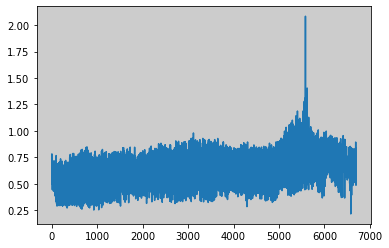

In [872]:
# remove seeds with low quality
mi = []
# dtws = [] # dtw and cosine similarity is almost same
cos_sim = []
for i in tqdm(list(range(aligned_ver2.shape[1]))):
    mi.append(morphotrack.track.mutual_information(std_values, aligned_ver2[:,i], bins=10))
    # dtws.append(dtw(std_values, aligned_ver2[:,i]))
    cos_sim.append(morphotrack.track.cosine_similarity(std_values, aligned_ver2[:,i]))
mi = np.asarray(mi)
# dtws = np.asarray(dtws)
cos_sim = np.asarray(cos_sim)


plt.plot(mi)

In [1397]:
# print(np.percentile(mi,50))
# print(np.percentile(cos_sim,50))

4313

0.6273109903903874
0.7670435176437579
1497


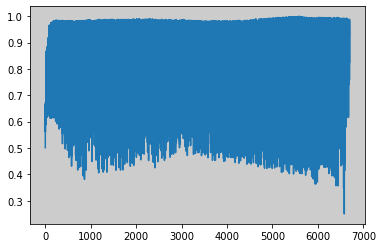

In [1419]:
# metrics = np.vstack([mi,cos_sim])
# metrics = zscore(metrics,axis=1)
# sns.clustermap(metrics, row_cluster=False)
th1 = threshold_otsu(mi)#np.percentile(mi,50)
th2 = threshold_otsu(cos_sim)#np.percentile(cos_sim,50)
print(th1)
print(th2)
plt.plot(cos_sim)
my_choice = np.asarray(seed_choice)[(mi>th1)*(cos_sim>th2)].tolist()
print(len(my_choice))

In [1440]:
# find 3D coordinate and map back into the 3D image for better visualization. Quality check
pos_img = np.zeros_like(asma_downscale)
for i, seed_num in enumerate(my_choice):
    virtual_rg = virtual_rgs[seed_num]
    positional_displacement = standard2target_ver2_df.loc[seed_num].to_numpy()
    positional_displacement[positional_displacement<0]=0 # clipping

    positions = virtual_rg.trajectory.ode_solution.y

    positional_displacement = positional_displacement[:positions.shape[1]]
    pos_img[tuple(positions.astype(int))] = positional_displacement
    
pos_img = pos_img * segmented_tissue.astype(np.uint16)
viewer = napari.Viewer()
viewer.add_image(pos_img, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='additive', multiscale=False)
viewer.add_image(autofl, contrast_limits=[0,5000], rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False, visible=False)


points_vis = seeds_df.iloc[:,0:3].reindex(my_choice)
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)

viewer2 = napari.Viewer()
viewer2.add_image(aligned_ver2_df.reindex(my_choice).to_numpy().T, rgb=False, name='aligned', colormap=turbo_dark, blending='additive', multiscale=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'aligned' at 0x7f356ef1f670>

[0.24013176 0.12114869 0.09221766 0.08084641 0.04541628 0.0447428
 0.03277949 0.03035387 0.02474309 0.01790013]
0.7302801679069882


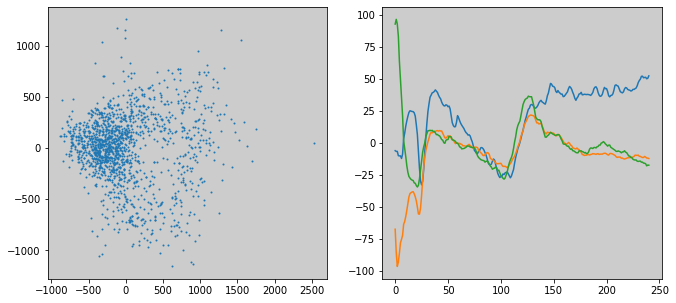

In [1673]:
# Can I do PCA/tSNE to the aligned space?
# However, pca only indicates how far from edge. It is an artifact and not biological.
from sklearn.decomposition import PCA

trim = 240
aligned_trimmed = aligned_ver2_df.loc[:,:trim].reindex(my_choice)
aligned_trimmed_zscore = zscore(aligned_trimmed,axis=0)
pca = PCA().fit(aligned_trimmed)
pcs = pca.transform(aligned_trimmed)
pc1 = pcs[:,0]
pc2 = pcs[:,1]

fig, axs = plt.subplots(ncols=2, figsize=(11,5))
axs[0].scatter(pc1,pc2,s=1)
#print(pca.explained_variance_ratio_)

component_num = 10
print(pca.explained_variance_ratio_[:component_num])
print(pca.explained_variance_ratio_[:component_num].sum())
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# fig, axs = plt.subplots(ncols=1, figsize=(5,5))
axs[1].plot(loadings[:,0])
axs[1].plot(loadings[:,1])
axs[1].plot(loadings[:,2])

# viewer = napari.Viewer()

# viewer.add_image(aligned_trimmed.T.to_numpy(), rgb=False, name='aligned', colormap='viridis', blending='additive', multiscale=False)
# viewer.add_image(zscore(aligned_trimmed.T.to_numpy(),axis=1), rgb=False, name='zscore', colormap='viridis', blending='additive', multiscale=False)

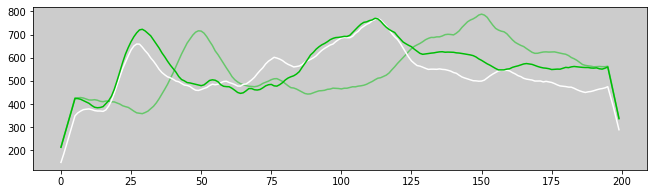

In [1670]:
fig, axs = plt.subplots(ncols=1, figsize=(11,3))
my_pos = 7
axs.plot(morphotrack.track.moving_average(target_df.reindex(my_choice).to_numpy().T[:200,my_pos]),c='#67c76b')
axs.plot(morphotrack.track.moving_average(std_values[:200]), c='white')
axs.plot(morphotrack.track.moving_average(aligned_ver2_df.reindex(my_choice).to_numpy().T[:200,my_pos]),c='#00bd06')
plt.savefig("/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/alignment_example.svg")

(0.6667019272252168, 4.431813768980088e-193)
(-0.01442049458292843, 0.577180741041842)
(0.15382005887249928, 2.202411178354008e-09)


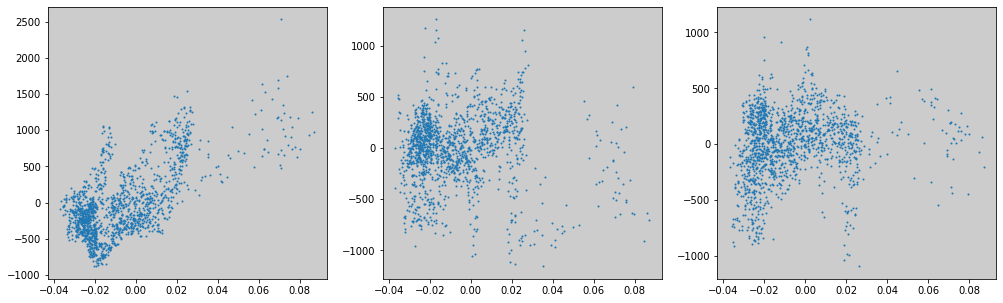

In [1469]:
fig, axs = plt.subplots(ncols=3, figsize=(17,5))
layer4_flux = layer_local_flux_df.reindex(my_choice).loc[:,2]

for i in range(3):
    axs[i].scatter(layer4_flux,pcs[:,i],s=1)

# sns.displot(pd.DataFrame(np.vstack([layer4_flux,pc1]).T),x=0,y=1, kind="kde",thresh=0.01)
print(pearsonr(layer4_flux,pcs[:,0]))
print(pearsonr(layer4_flux,pcs[:,1]))
print(pearsonr(layer4_flux,pcs[:,2]))
# plt.savefig("/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/pc1_local_flux_layer3.svg")

In [1682]:
# visualize the label in 3D with color

points_vis = seeds_df.iloc[:,0:3].reindex(my_choice)
viewer = napari.Viewer()

color_vis = color.get_colormap('viridis').map((pc1-np.percentile(pc1,2)) / (np.percentile(pc1,98)-np.percentile(pc1,2)))#((pc1-pc1.min()) / (pc1.max()-pc1.min()))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((pc2-np.percentile(pc2,2)) / (np.percentile(pc2,98)-np.percentile(pc2,2)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((layer4_flux-np.percentile(layer4_flux,2)) / (np.percentile(layer4_flux,98)-np.percentile(layer4_flux,2)))#((layer4_flux-layer4_flux.min()) / (layer4_flux.max()-layer4_flux.min()))
#color_vis = color.get_colormap('viridis').map((layer4_flux-np.min(layer4_flux)) / (np.max(layer4_flux)-np.min(layer4_flux)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)

viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,100000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3498fa0c10>

In [1489]:
# define function to calculate variable importance in projection
# https://github.com/scikit-learn/scikit-learn/issues/7050
def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [1504]:
# suppose the density is largely affected by divergence,
# how each positions of line are affected by divergence. test this with PLS.
# also read this. http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html
from sklearn.cross_decomposition import PLSRegression
from sklearn import model_selection

kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, aligned_trimmed_zscore, layer4_flux, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)
pls2 = PLSRegression(n_components=np.argmin(mse)).fit(aligned_trimmed_zscore,layer4_flux)

(0.0, 1.8)

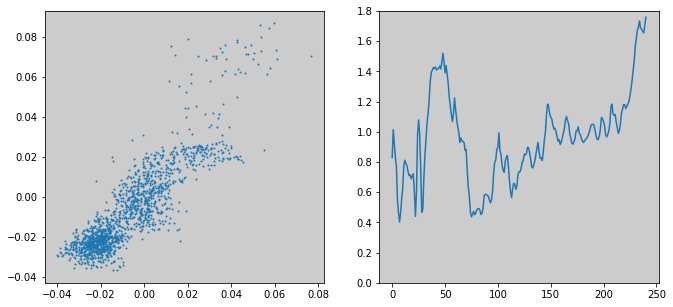

In [1681]:
fig, axs = plt.subplots(ncols=2, figsize=(11,5))
axs[0].scatter(pls2.predict(aligned_trimmed_zscore),layer4_flux,s=1)
axs[1].plot(vip(aligned_trimmed_zscore,layer4_flux,pls2))
axs[1].set_ylim([0, 1.8])
# fig, axs = plt.subplots(ncols=1, figsize=(11,3))
# axs.plot(vip(aligned_trimmed_zscore,layer4_flux,pls2))
# axs.set_ylim([0, 1.8])
# plt.savefig("/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/vip_anlaysis_layer.svg")

In [1655]:
viewer = napari.Viewer()
viewer.add_image(aligned_trimmed.T.to_numpy(), rgb=False, name='aligned', colormap='magma', blending='additive', multiscale=False)
viewer.add_image(aligned_trimmed_zscore.T.to_numpy(), rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)
viewer.add_image(target_df.reindex(my_choice).to_numpy().T, rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)
# viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[33:56,100:], rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)
# viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[77:100,100:], rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)
# viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[220:243,100:], rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)

<Image layer 'original' at 0x7f34d0ff5b80>

In [1553]:
# how much can I reduce the variance by analysing in my way?
# get bin and divide flux into 10 ranges
# measure SD in each range. SD of 
bin_num = 10
my_bin = np.arange(layer4_flux.min(),layer4_flux.max(),(layer4_flux.max()-layer4_flux.min())/bin_num)
idx = np.digitize(layer4_flux,my_bin)
idx_df = pd.DataFrame(idx,index=my_choice)
sum_count = []
for seed_num in my_choice:
    #tes = target_df.reindex(my_choice)[idx==i]
    cell_count = target_df.loc[seed_num,:]
    loc = round(standard2target_ver2_df.loc[seed_num,:].iloc[layer4[-1]])
    sum_count.append(cell_count.iloc[:loc].sum())
sum_count_df = pd.DataFrame(sum_count,index=my_choice)

In [1564]:
sd_percent = []
for i in range(1,idx.max()+1):
    sd = np.std(sum_count_df[idx==i].to_numpy())
    sd_percent.append(sd/sum_count_df[idx==i].mean().values)
    #sd_list.append()
sd_percent

[array([0.08312438]),
 array([0.12592723]),
 array([0.10199797]),
 array([0.11102986]),
 array([0.07035193]),
 array([0.10140826]),
 array([0.05348969]),
 array([0.13829879]),
 array([0.12956897]),
 array([0.10453193])]

In [1590]:
viewer = napari.Viewer()
viewer.add_image(aligned_ver2_df.reindex(my_choice).T.to_numpy()[:300,620:1310], rgb=False, name='aligned', colormap='viridis', blending='additive', multiscale=False)
#viewer.add_image(aligned_trimmed_zscore.T.to_numpy(), rgb=False, name='zscoreall', colormap='viridis', blending='additive', multiscale=False)
viewer.add_image(target_df.reindex(my_choice).to_numpy().T[:300,620:1310], rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)
#viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[:,::4], rgb=False, name='zscore_skipped', colormap='viridis', blending='additive', multiscale=False)


<Image layer 'original' at 0x7f35475aa250>

In [1698]:
# can I estimate radial glial density with aSMA?
skeleton = np.load(os.path.join(io_directory,'skeleton.npy'))

In [1716]:
viewer = napari.Viewer()

viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,100000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
viewer.add_image(asma_downscale*(~tes), contrast_limits=[0,100000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
viewer.add_image(skeleton, rgb=False, name='skeleton', colormap='yellow', blending='additive', multiscale=False,visible=False)
#viewer.add_image(skeleton*(~tes), contrast_limits=[0,50],rgb=False, name='segment', colormap='yellow', blending='additive', multiscale=False,visible=False)


<Image layer 'skeleton' at 0x7f3489dd8340>

In [1282]:
'''DBSCAN did not work because it connects all the population...'''
# # should I take into account the spatial information or clustering?
# # https://stackoverflow.com/questions/66406003/clustering-geospatial-data-on-coordinates-and-non-spatial-feature
# # how about getting pairwise mutual information?
# # both in before and after alignment.
# # before alignment. the length of vectors are adjusted to be same by simply cutting off the longer one.
# standard_end_pos = 300
# combination_mi_df = pd.DataFrame(columns=my_choice,index=my_choice)
# for s1, s2 in tqdm(list(itertools.combinations(my_choice,2))):
#     end_pos1 = round(standard2target_ver2_df.loc[s1,standard_end_pos])
#     end_pos2 = round(standard2target_ver2_df.loc[s2,standard_end_pos])
#     end_pos = np.min([end_pos1,end_pos2])
#     vec1 = target_df.loc[s1,:].to_numpy()[:end_pos]
#     vec2 = target_df.loc[s2,:].to_numpy()[:end_pos]
#     combination_mi_df.loc[s1,s2] = morphotrack.track.mutual_information(vec1, vec2, bins=10)
#     combination_mi_df.loc[s2,s1] = combination_mi_df.loc[s1,s2]
# # to fill diagonal
# for s in my_choice:
#     end_pos = round(standard2target_ver2_df.loc[s,standard_end_pos])
#     vec = target_df.loc[s,:].to_numpy()[:end_pos]
#     combination_mi_df.loc[s,s] = morphotrack.track.mutual_information(vec, vec, bins=10)
    
# # cosine similarity ver
# # before alignment. the length of vectors are adjusted to be same by simply cutting off the longer one.
# standard_end_pos = 300
# combination_cs_df = pd.DataFrame(columns=my_choice,index=my_choice,dtype=float)
# for s1, s2 in tqdm(list(itertools.combinations(my_choice,2))):
#     end_pos1 = round(standard2target_ver2_df.loc[s1,standard_end_pos])
#     end_pos2 = round(standard2target_ver2_df.loc[s2,standard_end_pos])
#     end_pos = np.min([end_pos1,end_pos2])
#     vec1 = target_df.loc[s1,:].to_numpy()[:end_pos]
#     vec2 = target_df.loc[s2,:].to_numpy()[:end_pos]
#     combination_cs_df.loc[s1,s2] = morphotrack.track.cosine_similarity(vec1, vec2)
#     combination_cs_df.loc[s2,s1] = combination_cs_df.loc[s1,s2]
# # to fill diagonal
# for s in my_choice:
#     end_pos = round(standard2target_ver2_df.loc[s,standard_end_pos])
#     vec = target_df.loc[s,:].to_numpy()[:end_pos]
#     combination_cs_df.loc[s,s] = morphotrack.track.cosine_similarity(vec, vec)
    
# # after alignment. 
# combination_mi_aligned_df = pd.DataFrame(columns=my_choice,index=my_choice, dtype=float)
# for s1, s2 in tqdm(list(itertools.combinations(my_choice,2))):
#     vec1 = aligned_ver2_df.loc[s1,:].to_numpy()[:standard_end_pos]
#     vec2 = aligned_ver2_df.loc[s2,:].to_numpy()[:standard_end_pos]
#     combination_mi_aligned_df.loc[s1,s2] = morphotrack.track.mutual_information(vec1, vec2, bins=10)
#     combination_mi_aligned_df.loc[s2,s1] = combination_mi_aligned_df.loc[s1,s2]

# # to fill diagonal
# for s in my_choice:
#     vec = aligned_ver2_df.loc[s,:].to_numpy()[:standard_end_pos]
#     combination_mi_aligned_df.loc[s,s] = morphotrack.track.mutual_information(vec, vec, bins=10)
    
# # DBSCAN using mutual information
# import hdbscan
# db = hdbscan.HDBSCAN(metric='precomputed',min_cluster_size=6)
# clusterer = db.fit((1/combination_cs_df-1).to_numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1119756/1119756 [11:04<00:00, 1685.16it/s]


In [1604]:
values = []

for i in range(4):
    #val = layer_cell_count[i,:]/layer_cell_count[i+1,:] #metric_of_choice
    val = np.log10(layer_cell_count[i,:]) - np.log10(layer_cell_count[i+1,:])
    # val = layer_cell_count_df.reindex(my_choice).to_numpy().T[i,:]/layer_cell_count_df.reindex(my_choice).to_numpy().T[i+1,:]
    # plow = np.percentile(val,15)
    # phigh = np.percentile(val,85)
    
    # val[val<plow] = plow
    # val[val>phigh] = phigh
    
    #values.append((val - np.median(val)) / (phigh - plow))
    values.append(val)
val_df = pd.DataFrame(np.vstack(values).T,index=seed_choice)
val_df = val_df.reindex(my_choice)

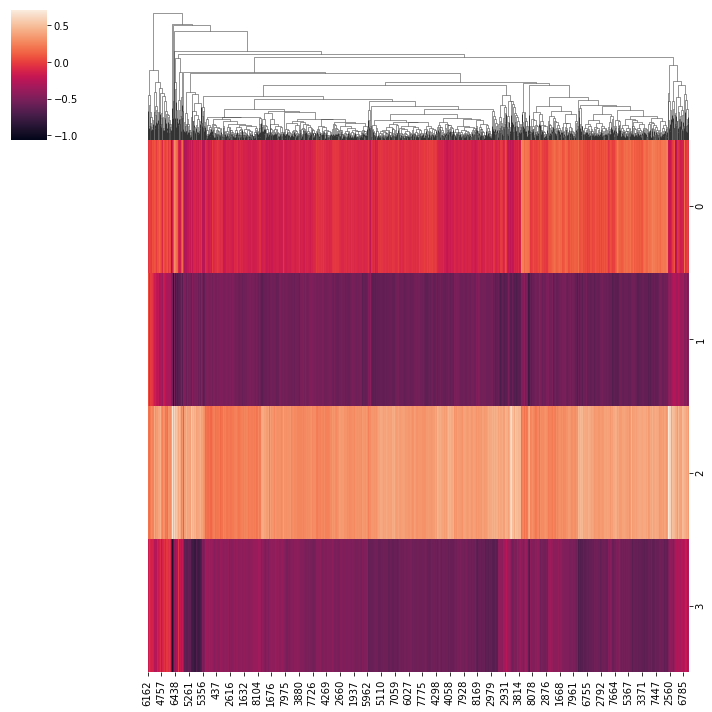

In [1605]:
import seaborn as sns
#from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering

# my_mtx = val_df.reindex(my_choice).T
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit(val_df)
label = cluster.labels_
# heatmap should look boring. This is the sampling highly biased onto the region with higher surface area
sns.clustermap(val_df.T, row_cluster=False)
label_df = pd.Series(label,index=my_choice)

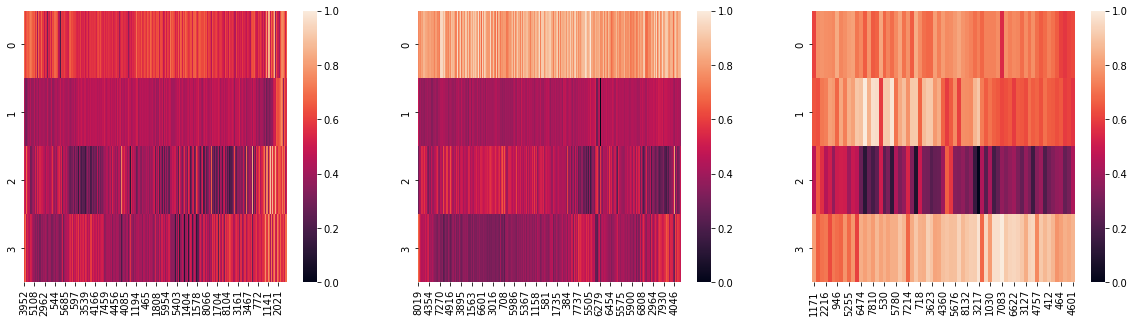

In [1606]:
_, freq = np.unique(label, return_counts=True)
val_df_norm = (val_df - val_df.min(axis=0)) / (val_df.max(axis=0) - val_df.min(axis=0))

fig, axs = plt.subplots(ncols=label.max()+1, figsize=(20,5))
for i in range(label.max()+1):
    sns.heatmap(val_df_norm[label==np.argsort(freq)[-i-1]].T,ax=axs[i],vmin=0.0,vmax=1.0)

In [1126]:
# tes = val_df.groupby(label).sample(n=freq.min())

In [1614]:
# do pca to extract "gyrus-ness"
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(val_df)
pcs = pca.transform(val_df)
pc1 = pcs[:,0]
pc2 = pcs[:,1]
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.46164911 0.2953492  0.12824598 0.11475571]
1.0


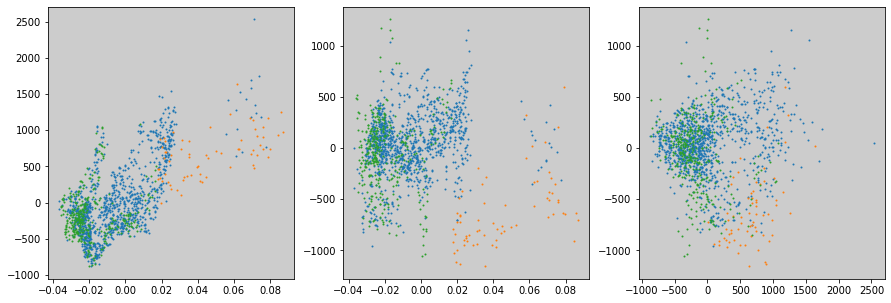

In [1720]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
layer4_flux = layer_local_flux_df.reindex(my_choice).loc[:,2]
for i in range(label.max()+1):
    axs[0].scatter(layer4_flux[label==i],pc1[label==i],s=1)
    axs[1].scatter(layer4_flux[label==i],pc2[label==i],s=1)
    axs[2].scatter(pc1[label==i],pc2[label==i],s=1)

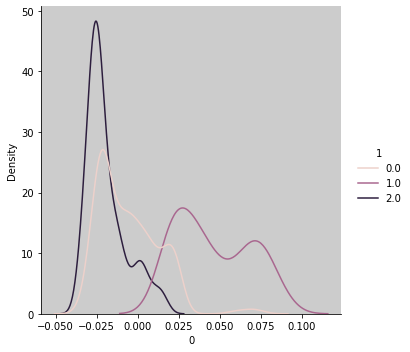

In [1230]:
sns.displot(pd.DataFrame(np.vstack([layer4_flux,label]).T),x=0,hue=1, kind="kde",common_norm=False,hue_order=(0,1,3,5,2,4))

In [1612]:
# visualize the label in 3D with color

points_vis = seeds_df.iloc[:,0:3].reindex(my_choice)
viewer = napari.Viewer()

#('viridis').map((pc1-np.percentile(pc1,2)) / (np.percentile(pc1,98)-np.percentile(pc1,2)))
# color_vis = color.get_colormap('viridis').map((label-label.min()) / (label.max()-label.min()))
# points = viewer.add_points(
#     points_vis,
#     size=10,
#     face_color = color_vis,
#     edge_width=0,
#     symbol='disc',
# )

color_vis = color.get_colormap('viridis').map((pc1-np.percentile(pc1,2)) / (np.percentile(pc1,98)-np.percentile(pc1,2)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((pc2-np.percentile(pc2,2)) / (np.percentile(pc2,98)-np.percentile(pc2,2)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((layer4_flux-np.percentile(layer4_flux,2)) / (np.percentile(layer4_flux,98)-np.percentile(layer4_flux,2)))#(layer4_flux-layer4_flux.min()) / (layer4_flux.max()-layer4_flux.min()))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)

viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3438418bb0>

In [1159]:
viewer = napari.Viewer()
shift = -100

for i in range(label_df.max()+1):
    my_tes = aligned_ver2_df.reindex(label_df[label_df==i].index)
    #my_tes = zscore(((my_tes) - (np.roll(my_tes,shift,axis=0))),axis=0)
    viewer.add_image(my_tes.to_numpy().T, rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False) # ((my_tes) - (np.roll(my_tes,shift,axis=0)))

In [ ]:
# def my_count_around_position(positions, flow, coords_tree, half_thickness, radius=20, size=None):
#     """
#     The function scan along a given coordinate and count the neighbors in a column.
#         position (ndarray): center of the column
#         flow (ndarray): axis of the column
#         coords_tree (ndarray or scipy kdtree): kdtree of the point cloud
#         half_thickness (float): half thickness of the column
#         radius (float): the radius of the column
#         return_all (bool): True to get counts, index and

#     return: counts, index, and coordinates
#     """
#     # convert coords to kdtree
#     if not isinstance(coords_tree, spatial.kdtree.KDTree):
#         coords_tree = spatial.KDTree(coords_tree)

#     coords = coords_tree.data
#     # get index of the neighbors. idx is an array of lists.
#     indices = coords_tree.query_ball_point(positions, r=radius, workers=-1)

#     # coords_in_thickness = []
#     # column_sum = []
#     # idx_in_thickness = []
#     print('1')
    
#     @ray.remote
#     def count_in_thickness(idx, neighbor_coords, p, f):
#         # neighbor_coords = coords[idx, :]
#         in_thickness, subidx = morphotrack.points.isin_thickness(half_thickness, p, f, neighbor_coords)
#         count_in_thickness = in_thickness.size
#         idx_in_thickness = np.asarray(idx)[subidx]
        
#         return in_thickness, count_in_thickness, idx_in_thickness
        
#     ans = []

#     # convert index to the xyz coordinate. to each array element (i.e. list), convert to coord.
#     for i, idx in enumerate(indices.tolist()):
#         neighbor_coords = coords[idx, :]
#         p = positions[i, :]
#         f = flow[i, :]
#         ans.append(count_in_thickness.remote(idx, neighbor_coords, p, f))

#     # column_sum = np.asarray(column_sum)
#     # if size is not None:
#     #     column_sum = np.pad(column_sum, (0, size - column_sum.size), 'constant',
#     #                         constant_values=(0, 0))  # pad to the size

#     print('2')
    
#     ans = ray.get(ans)
#     print('3')
#     return ans


# values = tracker.t_positions.copy()
# values = values.stack(pos=['time', 'track'])
# selection = ~np.isnan(values.data.T).any(axis=1)

# values2 = flow.stack(pos=['time', 'track'])
# selection2 = ~np.isnan(values2.data.T).any(axis=1)

# selection = selection & selection2

# values_selected = values.isel(pos=selection)
# values2_selected = values2.isel(pos=selection)


# half_thickness = 2.5 # * 10 micrometer. half of the thickness
# radius = 10 # * 10 micrometer

# tes = my_count_around_position(values_selected.data.T, values2_selected.data.T, coords_tree, half_thickness, radius)